In [35]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 

from scipy.io import arff

import matplotlib.pyplot as plt

In [2]:
data, meta = arff.loadarff('./Rice_Cammeo_Osmancik.arff')
df = pd.DataFrame(data)
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   float64
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   float64
 6   Extent             3810 non-null   float64
 7   Class              3810 non-null   object 
dtypes: float64(7), object(1)
memory usage: 387.6 KB


In [3]:
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = pd.to_numeric(df[col], downcast='float')

df['Class'] = df['Class'].str.decode('utf-8').astype('category')
df.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,Cammeo
1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,Cammeo
2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,Cammeo
3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,Cammeo
4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,Cammeo


In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df['Class'], test_size=0.2, random_state=99)

rfc = RandomForestClassifier(random_state=99)

params = {'n_estimators': [10, 50, 100, 200, 500],
        'criterion': ['gini', 'entropy', 'log_loss']
        }

gscv = GridSearchCV(rfc, param_grid=params, cv=5, n_jobs=-1)
gscv.fit(X_train, y_train)
print(gscv.best_params_)

rfc = RandomForestClassifier(**gscv.best_params_, random_state=99)

{'criterion': 'entropy', 'n_estimators': 100}


In [10]:
rfc.fit(X_train, y_train)
print(rfc.score(X_test, y_test))

0.9212598425196851


In [41]:
#Generate prediction set
np.random.seed(99)

def random_data(df, num_samples) -> np.array:
    return {k: np.random.normal(df[k].mean(), df[k].std(), num_samples) for k in df.columns if k != 'Class'}

pred_df = pd.DataFrame(random_data(df, 100))
pred_df

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
0,12421.108792,415.549253,212.604738,90.426542,0.866027,12480.856182,0.775876
1,16231.589747,483.470146,171.662229,77.175664,0.865641,14680.965146,0.757300
2,13158.440220,426.190493,178.716717,78.386429,0.889962,16371.859829,0.684810
3,14971.449037,510.974171,192.013134,87.124396,0.857614,9602.399007,0.806328
4,12399.864760,504.285224,181.872252,90.392753,0.889867,14316.357542,0.887980
...,...,...,...,...,...,...,...
95,14285.685591,420.434126,209.506290,90.626676,0.906846,13123.319955,0.621054
96,15357.458321,472.662932,171.221769,84.435152,0.878526,13004.296229,0.702940
97,12829.916670,500.301099,166.488239,89.389159,0.917482,14997.043311,0.747423
98,13178.473121,481.292964,206.580624,83.002179,0.906358,12636.649636,0.619656


In [51]:
result = pd.Series(rfc.predict(pred_df))
pred_df['Class'] = result

print(f"Generated Values: \n\n{result.value_counts()} \n\n\nActual Values: \n\n{df['Class'].value_counts()}")

Generated Values: 

Osmancik    56
Cammeo      44
Name: count, dtype: int64 


Actual Values: 

Class
Osmancik    2180
Cammeo      1630
Name: count, dtype: int64


In [43]:
real_osm = df['Class'].value_counts()['Osmancik']
real_cam = df['Class'].value_counts()['Cammeo']

pred_osm = result.value_counts()['Osmancik']
pred_cam = result.value_counts()['Cammeo']

print(f" Actual Class Ratio (Osmancik/Cameo): {(real_osm/real_cam):.2f} \n Random Data Prediction Ratio (Osmancik/Cameo):{(pred_osm/pred_cam):.2f}")

 Actual Class Ratio (Osmancik/Cameo): 1.34 
 Random Data Prediction Ratio (Osmancik/Cameo):1.27


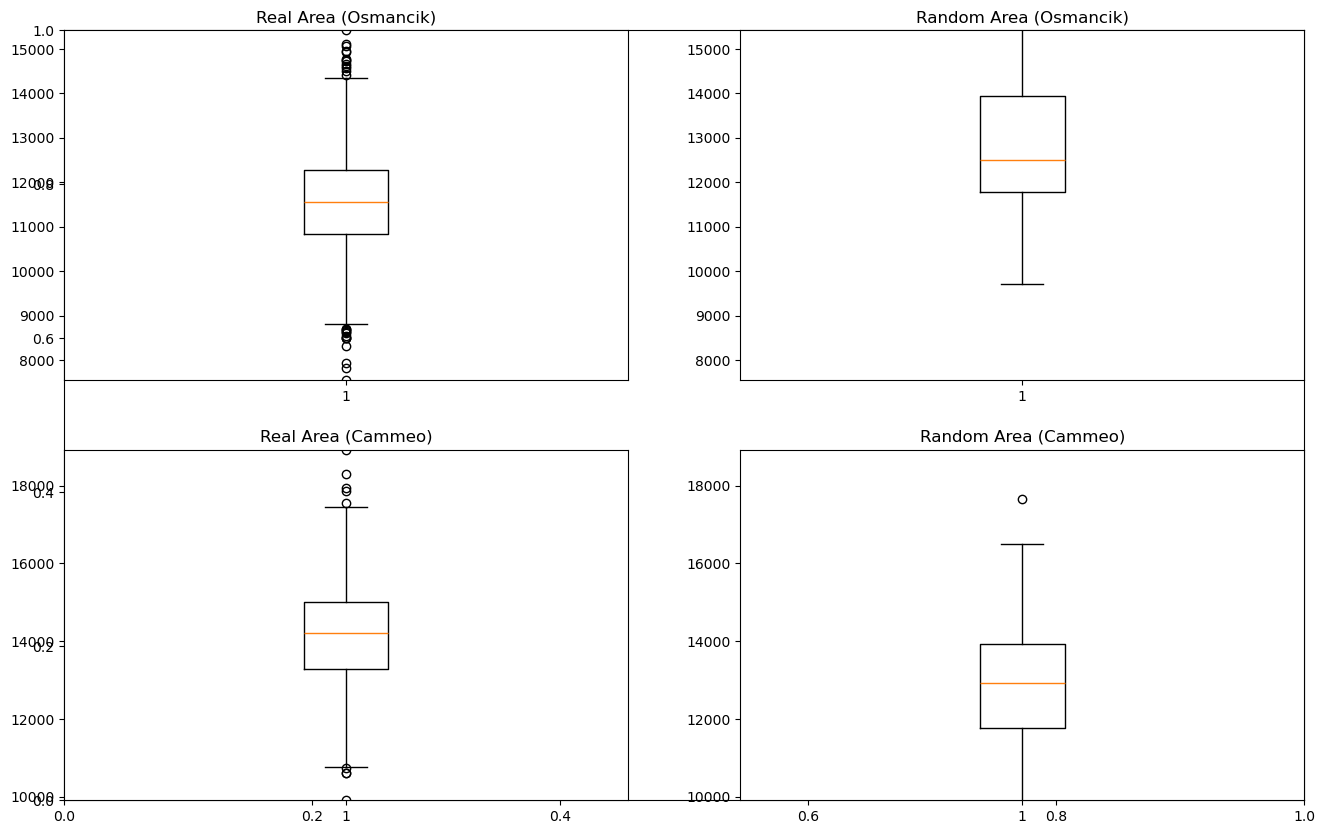

In [67]:
plt.subplots(figsize=(16, 10))

#Real Area Osmancik
plt.subplot(2, 2, 1)
plt.boxplot(df[df["Class"] == 'Osmancik']['Area'])
plt.ylim(df[df["Class"] == 'Osmancik']['Area'].min(), df[df["Class"] == 'Osmancik']['Area'].max())

plt.title('Real Area (Osmancik)')

#Random Area Osmancik
plt.subplot(2, 2, 2)
plt.boxplot(pred_df[pred_df["Class"] == 'Osmancik']['Area'])
plt.ylim(df[df["Class"] == 'Osmancik']['Area'].min(), df[df["Class"] == 'Osmancik']['Area'].max())

plt.title('Random Area (Osmancik)')

#Real Area Cammeo
plt.subplot(2, 2, 3)
plt.boxplot(df[df["Class"] == 'Cammeo']['Area'])
plt.ylim(df[df["Class"] == 'Cammeo']['Area'].min(), df[df["Class"] == 'Cammeo']['Area'].max())

plt.title('Real Area (Cammeo)')

#Random Area Cammeo
plt.subplot(2, 2, 4)
plt.boxplot(pred_df[pred_df["Class"] == 'Cammeo']['Area'])
plt.ylim(df[df["Class"] == 'Cammeo']['Area'].min(), df[df["Class"] == 'Cammeo']['Area'].max())

plt.title('Random Area (Cammeo)')

plt.show()

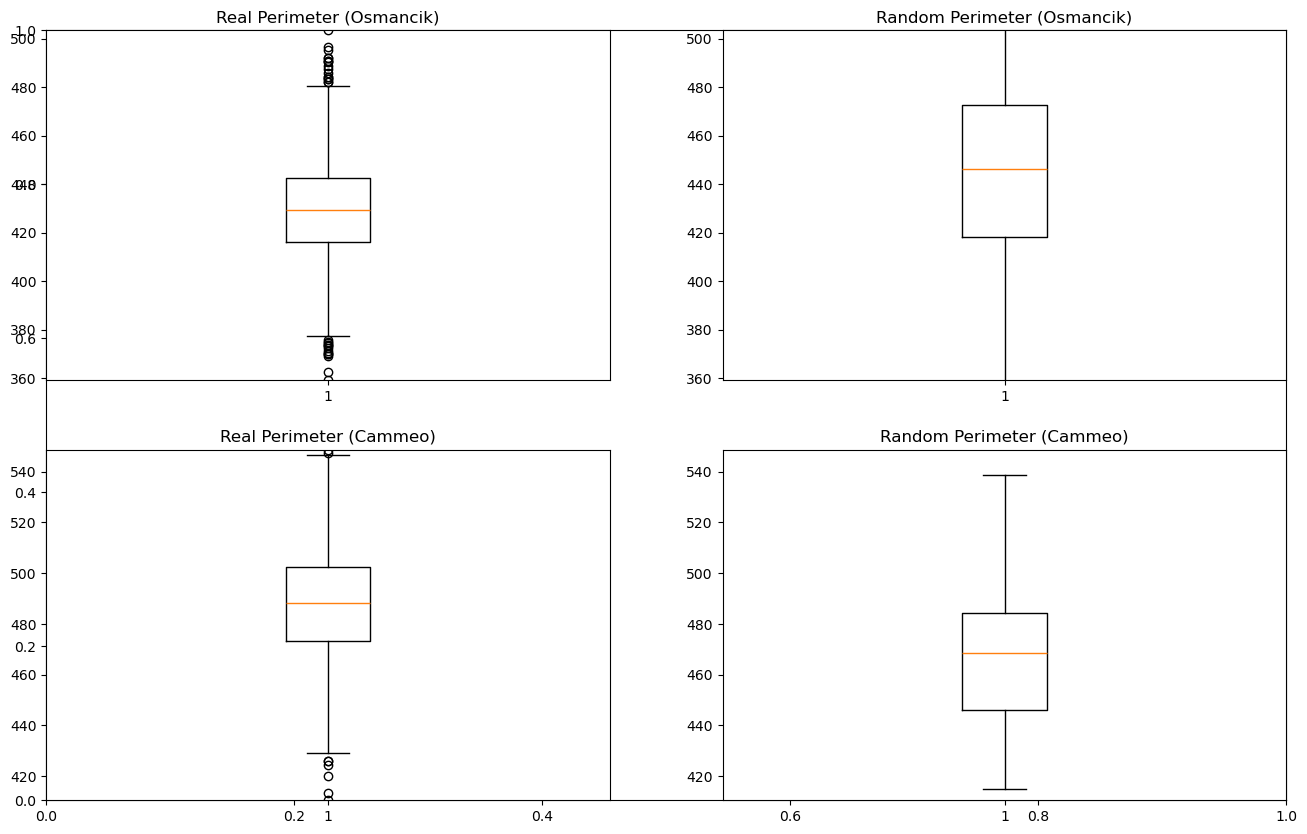

In [77]:
plt.subplots(figsize=(16, 10))

#Real Perimeter Osmancik
plt.subplot(2, 2, 1)
plt.boxplot(df[df["Class"] == 'Osmancik']['Perimeter'])
plt.ylim(df[df["Class"] == 'Osmancik']['Perimeter'].min(), df[df["Class"] == 'Osmancik']['Perimeter'].max())

plt.title('Real Perimeter (Osmancik)')

#Random Perimeter Osmancik
plt.subplot(2, 2, 2)
plt.boxplot(pred_df[pred_df["Class"] == 'Osmancik']['Perimeter'])
plt.ylim(df[df["Class"] == 'Osmancik']['Perimeter'].min(), df[df["Class"] == 'Osmancik']['Perimeter'].max())

plt.title('Random Perimeter (Osmancik)')

#Real Perimeter Cammeo
plt.subplot(2, 2, 3)
plt.boxplot(df[df["Class"] == 'Cammeo']['Perimeter'])
plt.ylim(df[df["Class"] == 'Cammeo']['Perimeter'].min(), df[df["Class"] == 'Cammeo']['Perimeter'].max())

plt.title('Real Perimeter (Cammeo)')

#Random Perimeter Cammeo
plt.subplot(2, 2, 4)
plt.boxplot(pred_df[pred_df["Class"] == 'Cammeo']['Perimeter'])
plt.ylim(df[df["Class"] == 'Cammeo']['Perimeter'].min(), df[df["Class"] == 'Cammeo']['Perimeter'].max())

plt.title('Random Perimeter (Cammeo)')

plt.show()

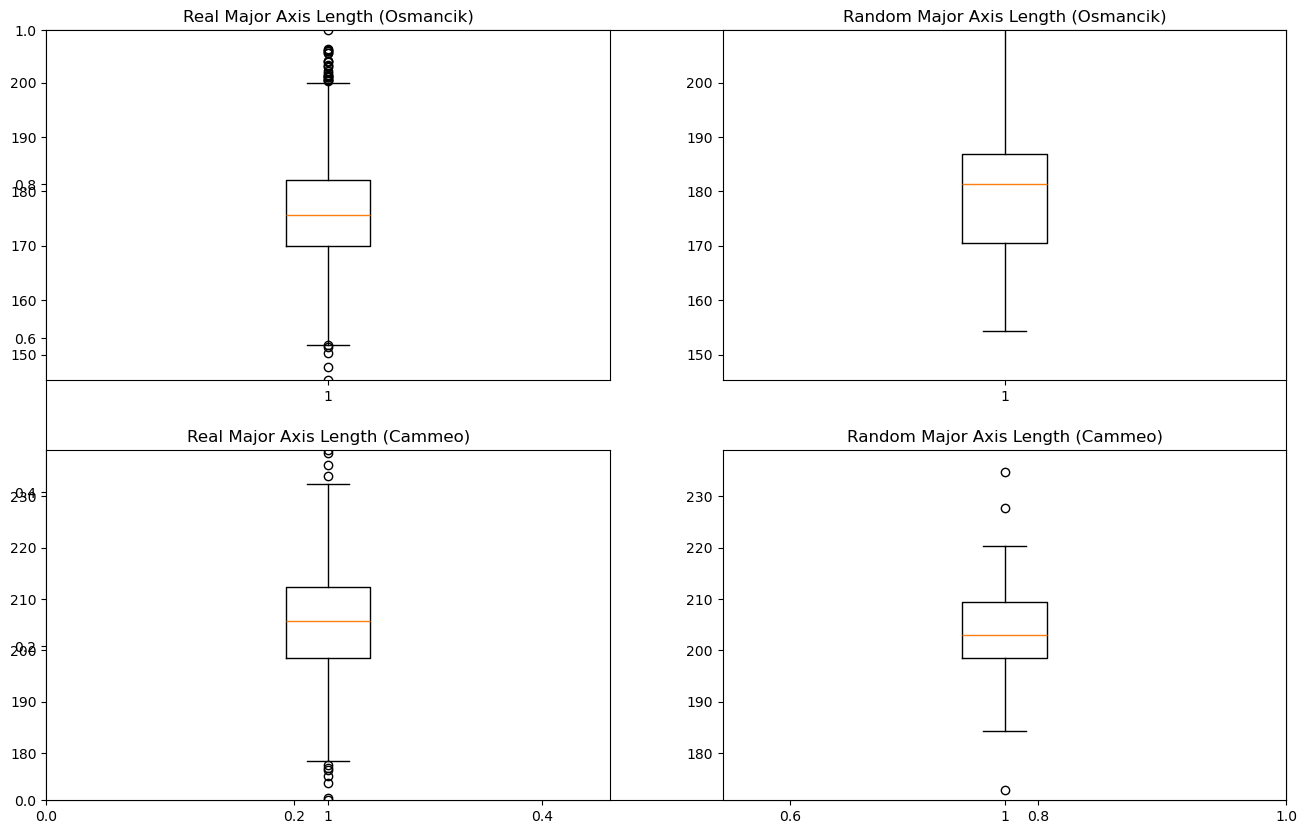

In [78]:
plt.subplots(figsize=(16, 10))

#Real MajorAxisLength Osmancik
plt.subplot(2, 2, 1)
plt.boxplot(df[df["Class"] == 'Osmancik']['Major_Axis_Length'])
plt.ylim(df[df["Class"] == 'Osmancik']['Major_Axis_Length'].min(), df[df["Class"] == 'Osmancik']['Major_Axis_Length'].max())

plt.title('Real Major Axis Length (Osmancik)')

#Random MajorAxisLength Osmancik
plt.subplot(2, 2, 2)
plt.boxplot(pred_df[pred_df["Class"] == 'Osmancik']['Major_Axis_Length'])
plt.ylim(df[df["Class"] == 'Osmancik']['Major_Axis_Length'].min(), df[df["Class"] == 'Osmancik']['Major_Axis_Length'].max())

plt.title('Random Major Axis Length (Osmancik)')

#Real MajorAxisLength Cammeo
plt.subplot(2, 2, 3)
plt.boxplot(df[df["Class"] == 'Cammeo']['Major_Axis_Length'])
plt.ylim(df[df["Class"] == 'Cammeo']['Major_Axis_Length'].min(), df[df["Class"] == 'Cammeo']['Major_Axis_Length'].max())

plt.title('Real Major Axis Length (Cammeo)')

#Random MajorAxisLength Cammeo
plt.subplot(2, 2, 4)
plt.boxplot(pred_df[pred_df["Class"] == 'Cammeo']['Major_Axis_Length'])
plt.ylim(df[df["Class"] == 'Cammeo']['Major_Axis_Length'].min(), df[df["Class"] == 'Cammeo']['Major_Axis_Length'].max())

plt.title('Random Major Axis Length (Cammeo)')

plt.show()

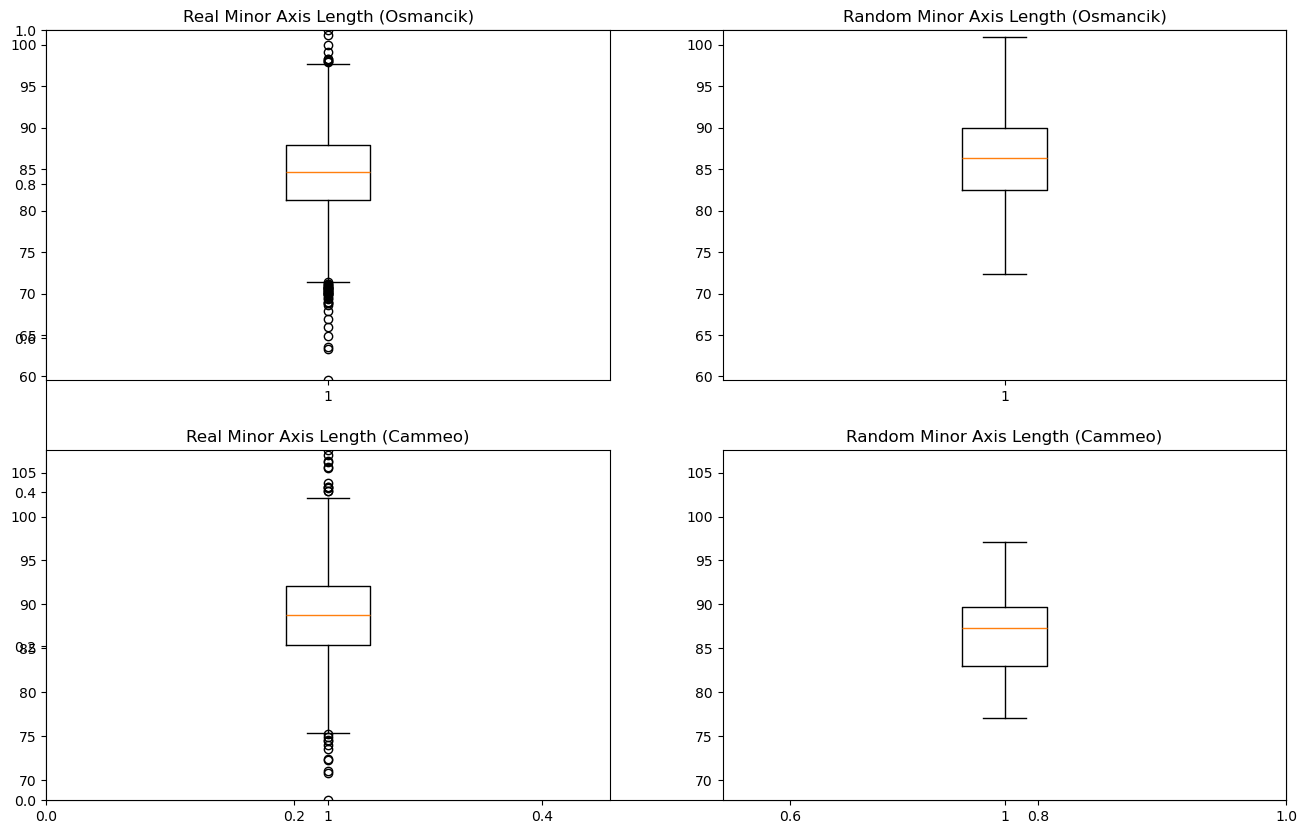

In [79]:
plt.subplots(figsize=(16, 10))

#Real MinorAxisLength Osmancik
plt.subplot(2, 2, 1)
plt.boxplot(df[df["Class"] == 'Osmancik']['Minor_Axis_Length'])
plt.ylim(df[df["Class"] == 'Osmancik']['Minor_Axis_Length'].min(), df[df["Class"] == 'Osmancik']['Minor_Axis_Length'].max())

plt.title('Real Minor Axis Length (Osmancik)')

#Random MinorAxisLength Osmancik
plt.subplot(2, 2, 2)
plt.boxplot(pred_df[pred_df["Class"] == 'Osmancik']['Minor_Axis_Length'])
plt.ylim(df[df["Class"] == 'Osmancik']['Minor_Axis_Length'].min(), df[df["Class"] == 'Osmancik']['Minor_Axis_Length'].max())

plt.title('Random Minor Axis Length (Osmancik)')

#Real MinorAxisLength Cammeo
plt.subplot(2, 2, 3)
plt.boxplot(df[df["Class"] == 'Cammeo']['Minor_Axis_Length'])
plt.ylim(df[df["Class"] == 'Cammeo']['Minor_Axis_Length'].min(), df[df["Class"] == 'Cammeo']['Minor_Axis_Length'].max())

plt.title('Real Minor Axis Length (Cammeo)')

#Random MinorAxisLength Cammeo
plt.subplot(2, 2, 4)
plt.boxplot(pred_df[pred_df["Class"] == 'Cammeo']['Minor_Axis_Length'])
plt.ylim(df[df["Class"] == 'Cammeo']['Minor_Axis_Length'].min(), df[df["Class"] == 'Cammeo']['Minor_Axis_Length'].max())

plt.title('Random Minor Axis Length (Cammeo)')

plt.show()

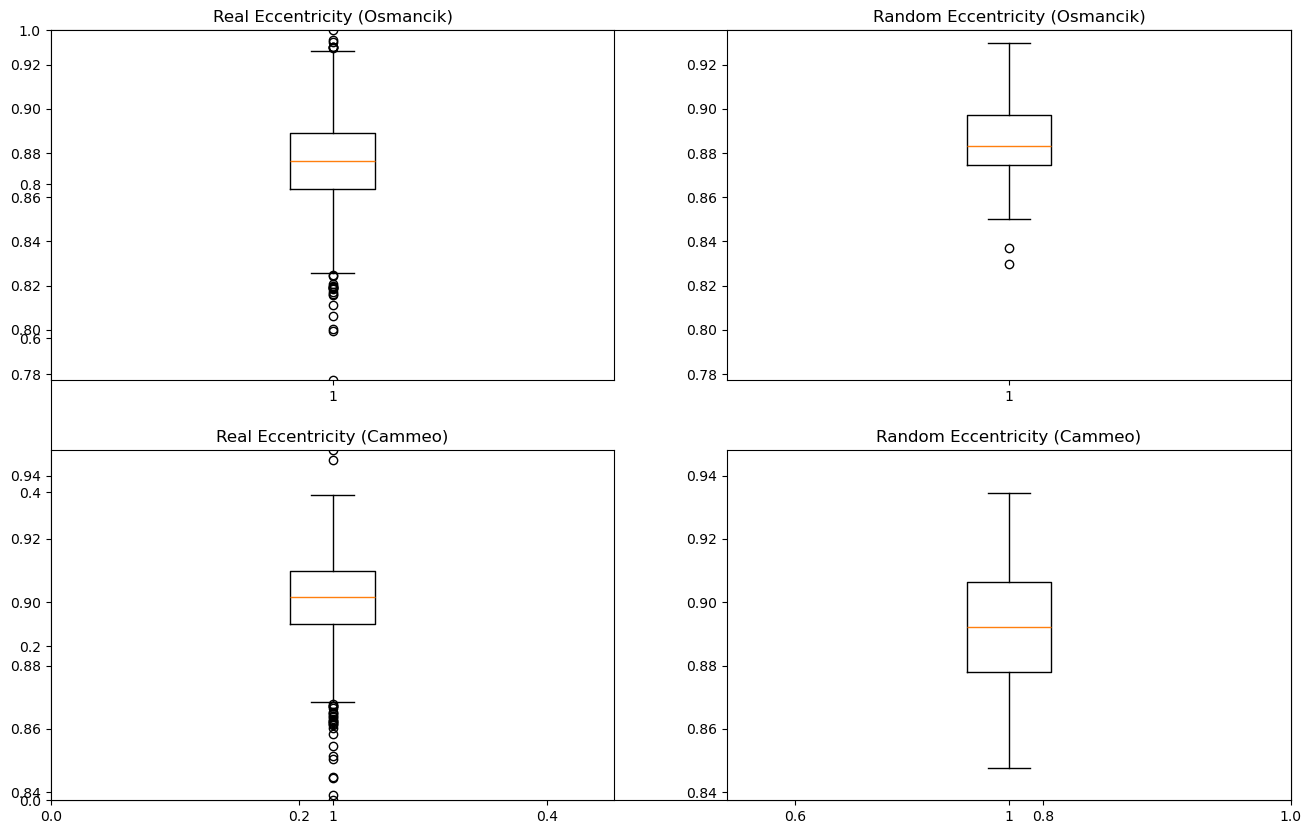

In [80]:
plt.subplots(figsize=(16, 10))

#Real Eccentricity Osmancik
plt.subplot(2, 2, 1)
plt.boxplot(df[df["Class"] == 'Osmancik']['Eccentricity'])
plt.ylim(df[df["Class"] == 'Osmancik']['Eccentricity'].min(), df[df["Class"] == 'Osmancik']['Eccentricity'].max())

plt.title('Real Eccentricity (Osmancik)')

#Random Eccentricity Osmancik
plt.subplot(2, 2, 2)
plt.boxplot(pred_df[pred_df["Class"] == 'Osmancik']['Eccentricity'])
plt.ylim(df[df["Class"] == 'Osmancik']['Eccentricity'].min(), df[df["Class"] == 'Osmancik']['Eccentricity'].max())

plt.title('Random Eccentricity (Osmancik)')

#Real Eccentricity Cammeo
plt.subplot(2, 2, 3)
plt.boxplot(df[df["Class"] == 'Cammeo']['Eccentricity'])
plt.ylim(df[df["Class"] == 'Cammeo']['Eccentricity'].min(), df[df["Class"] == 'Cammeo']['Eccentricity'].max())

plt.title('Real Eccentricity (Cammeo)')

#Random Eccentricity Cammeo
plt.subplot(2, 2, 4)
plt.boxplot(pred_df[pred_df["Class"] == 'Cammeo']['Eccentricity'])
plt.ylim(df[df["Class"] == 'Cammeo']['Eccentricity'].min(), df[df["Class"] == 'Cammeo']['Eccentricity'].max())

plt.title('Random Eccentricity (Cammeo)')

plt.show()


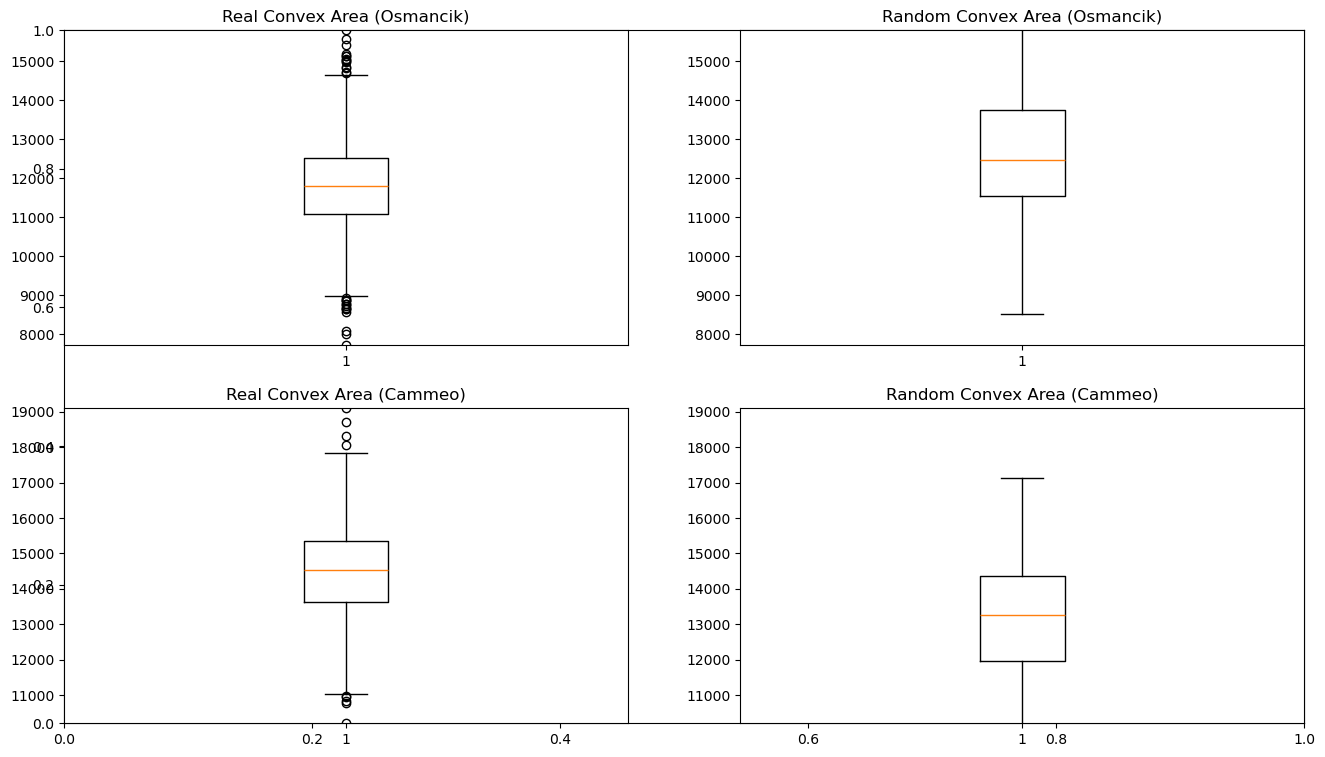

In [81]:
plt.subplots(figsize=(16,9))

#Real ConvexArea Osmancik
plt.subplot(2, 2, 1)
plt.boxplot(df[df["Class"] == 'Osmancik']['Convex_Area'])
plt.ylim(df[df["Class"] == 'Osmancik']['Convex_Area'].min(), df[df["Class"] == 'Osmancik']['Convex_Area'].max())

plt.title('Real Convex Area (Osmancik)')

#Random ConvexArea Osmancik
plt.subplot(2, 2, 2)
plt.boxplot(pred_df[pred_df["Class"] == 'Osmancik']['Convex_Area'])
plt.ylim(df[df["Class"] == 'Osmancik']['Convex_Area'].min(), df[df["Class"] == 'Osmancik']['Convex_Area'].max())

plt.title('Random Convex Area (Osmancik)')

#Real ConvexArea Cammeo
plt.subplot(2, 2, 3)
plt.boxplot(df[df["Class"] == 'Cammeo']['Convex_Area'])
plt.ylim(df[df["Class"] == 'Cammeo']['Convex_Area'].min(), df[df["Class"] == 'Cammeo']['Convex_Area'].max())

plt.title('Real Convex Area (Cammeo)')

#Random ConvexArea Cammeo
plt.subplot(2, 2, 4)
plt.boxplot(pred_df[pred_df["Class"] == 'Cammeo']['Convex_Area'])
plt.ylim(df[df["Class"] == 'Cammeo']['Convex_Area'].min(), df[df["Class"] == 'Cammeo']['Convex_Area'].max())

plt.title('Random Convex Area (Cammeo)')

plt.show()

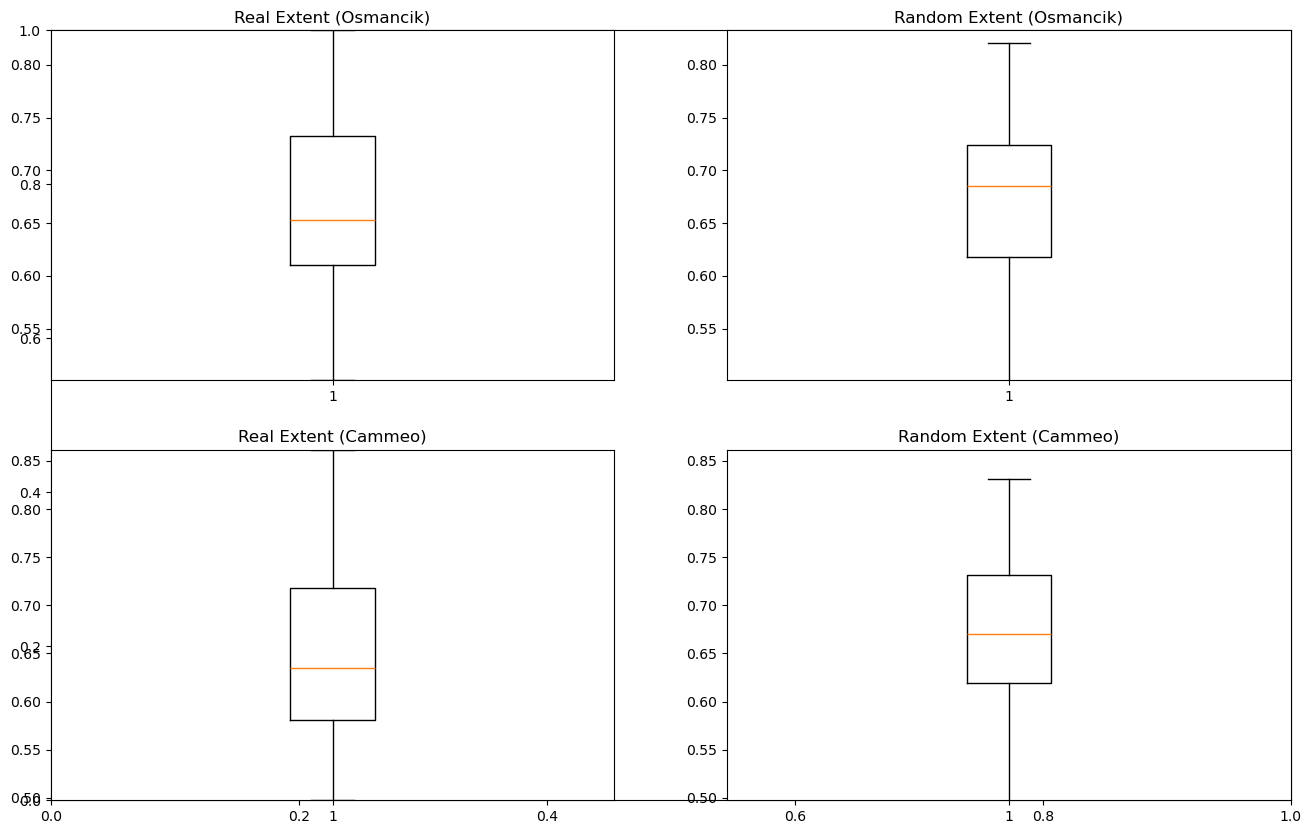

In [82]:
plt.subplots(figsize=(16, 10))

#Real Extent Osmancik
plt.subplot(2, 2, 1)
plt.boxplot(df[df["Class"] == 'Osmancik']['Extent'])
plt.ylim(df[df["Class"] == 'Osmancik']['Extent'].min(), df[df["Class"] == 'Osmancik']['Extent'].max())

plt.title('Real Extent (Osmancik)')

#Random Extent Osmancik
plt.subplot(2, 2, 2)
plt.boxplot(pred_df[pred_df["Class"] == 'Osmancik']['Extent'])
plt.ylim(df[df["Class"] == 'Osmancik']['Extent'].min(), df[df["Class"] == 'Osmancik']['Extent'].max())

plt.title('Random Extent (Osmancik)')

#Real Extent Cammeo
plt.subplot(2, 2, 3)
plt.boxplot(df[df["Class"] == 'Cammeo']['Extent'])
plt.ylim(df[df["Class"] == 'Cammeo']['Extent'].min(), df[df["Class"] == 'Cammeo']['Extent'].max())

plt.title('Real Extent (Cammeo)')

#Random Extent Cammeo
plt.subplot(2, 2, 4)
plt.boxplot(pred_df[pred_df["Class"] == 'Cammeo']['Extent'])
plt.ylim(df[df["Class"] == 'Cammeo']['Extent'].min(), df[df["Class"] == 'Cammeo']['Extent'].max())

plt.title('Random Extent (Cammeo)')

plt.show()